# Algorithm Chains and Pipelines

In [1]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
cancer = load_breast_cancer()

In [3]:
Xtrain,Xtest,ytrain,ytest = train_test_split(cancer.data, cancer.target, random_state=0)

In [4]:
scaler = MinMaxScaler().fit(Xtrain)

In [5]:
Xtrain_scaler = scaler.transform(Xtrain)
Xtest_scaler = scaler.transform(Xtest)

In [6]:
svc = SVC().fit(Xtrain_scaler, ytrain)
print('test score: {:.3f}'.format(svc.score(Xtest_scaler, ytest)))

test score: 0.972


### Parameter Selection with Preprocessing, below is problematic

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
params = {'C':[0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}

In [9]:
grid = GridSearchCV(SVC(), params, cv=5)
grid.fit(Xtrain_scaler, ytrain) # the scaler already learn the validation set in Xtrain dataset, this is problematic

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100]})

In [10]:
print('best validation score: {:.3f}'.format(grid.best_score_))
print('best test score: {:.3f}'.format(grid.score(Xtest_scaler, ytest)))
print('best estimators', grid.best_params_)

best validation score: 0.981
best test score: 0.972
best estimators {'C': 1, 'gamma': 1}


In [11]:
grid.best_estimator_.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [12]:
import mglearn

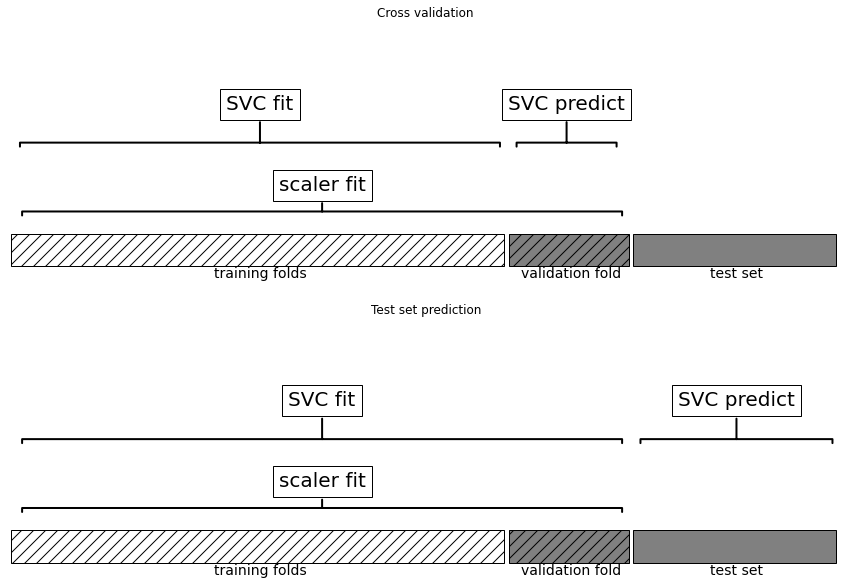

In [13]:
mglearn.plots.plot_improper_processing()

### Building Pipelines, this fixes the problem above

In [14]:
from sklearn.pipeline import Pipeline

In [15]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('clf', SVC())])

In [16]:
pipe.fit(Xtrain, ytrain)

Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', SVC())])

In [17]:
pipe.score(Xtest, ytest)

0.972027972027972

### use GridSearch for best parameters

In [18]:
params_= [{'clf__C':[0.001, 0.01, 0.1, 1, 10, 100], 'clf__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}]

In [19]:
Grid = GridSearchCV(pipe, params_, cv=5)
Grid.fit(Xtrain,ytrain)
print('best validation score: {:.3f}'.format(Grid.best_score_))
print('best test score: {:.3f}'.format(Grid.score(Xtest, ytest)))
print('best estimators', Grid.best_params_)

best validation score: 0.981
best test score: 0.972
best estimators {'clf__C': 1, 'clf__gamma': 1}


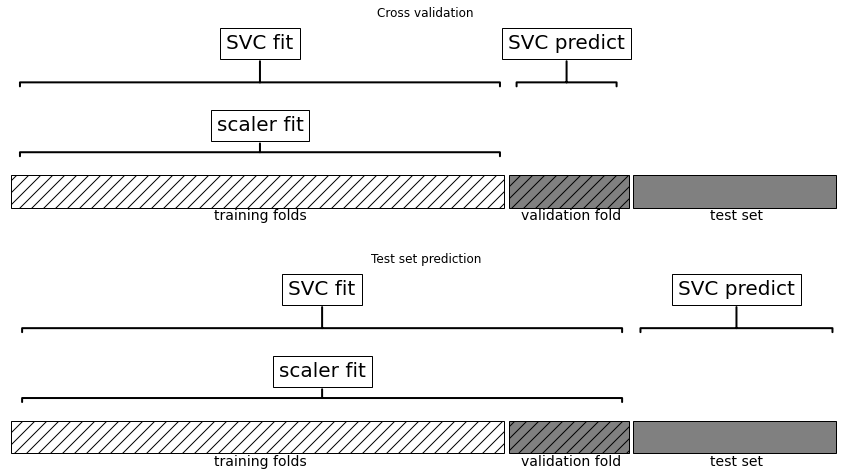

In [20]:
mglearn.plots.plot_proper_processing()

### The General Pipeline Interface

In [21]:
for name, estimator in pipe.steps[:-1]:
    print(name)
    print(estimator)

scaler
MinMaxScaler()


In [22]:
pipe.steps[:-1]

[('scaler', MinMaxScaler())]

In [23]:
pipe.steps[-1][1]

SVC()

In [24]:
def fit(self, X, y):
    Xtransformed = X
    for name, estimator in self.steps[:-1]:
        Xtransformed  = estimator.fit_transform(Xtransformed, y)
    self.steps[-1][1].fit(Xtransformed, y)
    return self

In [25]:
def predict(self, X):
    Xtransformed = X
    for name, estimator, in self.steps[:-1]:
        Xtransformed = estimator.fit_transform(Xtransformed)
    return self.steps[-1][1].predict(Xtransformed)

# Convenient Pipeline Creation with make_pipeline

In [26]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [27]:
pipe_short = make_pipeline(MinMaxScaler(), SVC())
pipe_long = Pipeline([('scaler',MinMaxScaler() ),('clf', SVC())])

In [28]:
pipe_short.steps # but pipe_short has steps that were automatically named

[('minmaxscaler', MinMaxScaler()), ('svc', SVC())]

In [29]:
pipe_long.steps

[('scaler', MinMaxScaler()), ('clf', SVC())]

In [30]:
pipe_short1 = make_pipeline(StandardScaler(), PCA(), StandardScaler())

In [31]:
pipe_short1.steps #pipe_short1.steps 

[('standardscaler-1', StandardScaler()),
 ('pca', PCA()),
 ('standardscaler-2', StandardScaler())]

### Accessing Step Attributes

In [32]:
pipe_short1.fit(cancer.data)

Pipeline(steps=[('standardscaler-1', StandardScaler()), ('pca', PCA()),
                ('standardscaler-2', StandardScaler())])

In [33]:
pipe_short1[1].n_components_

30

In [34]:
pipe_short1.named_steps # that returns a tuple

{'standardscaler-1': StandardScaler(),
 'pca': PCA(),
 'standardscaler-2': StandardScaler()}

In [35]:
pipe_short1.named_steps['pca'].n_components_

30

In [36]:
pipe_short1.steps # that returns a list

[('standardscaler-1', StandardScaler()),
 ('pca', PCA()),
 ('standardscaler-2', StandardScaler())]

In [37]:
pipe_short1.steps[1][-1].n_components_

30

### Accessing Attributes in a Grid-Searched Pipeline

In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
pip = make_pipeline(StandardScaler(), LogisticRegression())

In [40]:
Xtrain, Xtest,ytrain, ytest = train_test_split(cancer.data, cancer.target, random_state=0)

In [41]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [42]:
gd = GridSearchCV(pip, param_grid, cv=5)
gd.fit(Xtrain, ytrain)

/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]})

In [117]:
gd.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(C=1))])

In [115]:
gd.best_estimator_.named_steps['logisticregression'].get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [118]:
gd.best_estimator_.named_steps['logisticregression'].coef_

array([[-0.29792942, -0.58056355, -0.3109406 , -0.377129  , -0.11984232,
         0.42855478, -0.71131106, -0.85371164, -0.46688191,  0.11762548,
        -1.38262136,  0.0899184 , -0.94778563, -0.94686238,  0.18575731,
         0.99305313,  0.11090349, -0.3458275 ,  0.20290919,  0.80470317,
        -0.91626377, -0.91726667, -0.8159834 , -0.86539197, -0.45539191,
         0.10347391, -0.83009341, -0.98445173, -0.5920036 , -0.61086989]])

### Grid-Searching Preprocessing Steps and Model Parameters

In [127]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

In [120]:
boston = load_boston()

In [161]:
Xtrain, Xtest, ytrain, ytest = train_test_split(boston.data, boston.target, random_state=0)
pipe= make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())
params = {'polynomialfeatures__degree': [1, 2, 3],'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
Grid = GridSearchCV(pipe, params, cv=5)
Grid.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'polynomialfeatures__degree': [1, 2, 3],
                         'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [135]:
Grid.best_estimator_.steps

[('standardscaler', StandardScaler()),
 ('polynomialfeatures', PolynomialFeatures()),
 ('ridge', Ridge(alpha=10))]

In [140]:
Grid.best_estimator_.named_steps['ridge']

Ridge(alpha=10)

In [142]:
import pandas as pd

In [144]:
pd.DataFrame(Grid.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.005947,0.001682,0.001245,0.001224,0.00117,0.001077,0.003037,0.001838,0.001525,0.00148,0.001549,0.001589,0.006901,0.005311,0.004027,0.004319,0.00426,0.004039
std_fit_time,0.008481,0.000156,0.000139,0.000153,0.000085,0.000011,0.002345,0.000427,0.000083,0.000071,0.000122,0.000176,0.00353,0.001125,0.000265,0.000053,0.000181,0.000378
mean_score_time,0.00137,0.000711,0.00044,0.000419,0.000379,0.000396,0.000554,0.000508,0.00049,0.000513,0.000532,0.000497,0.001051,0.001,0.000893,0.000909,0.0009,0.000931
std_score_time,0.001258,0.000187,0.000062,0.000059,0.000003,0.000049,0.000064,0.000024,0.000016,0.000031,0.000063,0.000021,0.00007,0.000087,0.000088,0.000057,0.000087,0.000078
param_polynomialfeatures__degree,1,1,1,1,1,1,2,2,2,2,2,2,3,3,3,3,3,3
param_ridge__alpha,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100,0.001,0.01,0.1,1,10,100
params,"{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 1, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 2, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph...","{'polynomialfeatures__degree': 3, 'ridge__alph..."
split0_test_score,0.762602,0.762617,0.76276,0.76414,0.773967,0.781747,0.813194,0.816558,0.817204,0.831909,0.866518,0.871595,-1.126277,-0.389726,0.383167,0.831291,0.914146,0.905149
split1_test_score,0.56956,0.569557,0.569525,0.569216,0.567556,0.593544,0.639721,0.635223,0.641411,0.631069,0.618056,0.623519,-21.17717,-7.33049,-3.108991,-1.268576,-0.153154,0.264908
split2_test_score,0.779352,0.779353,0.77936,0.77941,0.778461,0.744269,0.631639,0.628425,0.627082,0.731638,0.877198,0.840461,-2883.048048,-797.614091,-64.588928,-1.33239,0.77717,0.343448


In [148]:
pd.DataFrame(Grid.cv_results_).T.loc['mean_test_score']

0       0.721916
1       0.721919
2       0.721954
3       0.722266
4       0.723326
5       0.707952
6       0.760171
7       0.759448
8       0.766651
9       0.794967
10      0.828726
11      0.804833
12   -581.095202
13   -160.898751
14    -13.197286
15     -0.031793
16      0.648341
17      0.654083
Name: mean_test_score, dtype: object

In [149]:
Grid.cv_results_

{'mean_fit_time': array([0.00594702, 0.00168219, 0.00124497, 0.00122385, 0.00116992,
        0.00107698, 0.00303712, 0.00183797, 0.0015254 , 0.00148015,
        0.00154872, 0.00158873, 0.00690084, 0.00531135, 0.00402675,
        0.00431871, 0.00425982, 0.00403876]),
 'std_fit_time': array([8.48149109e-03, 1.56189946e-04, 1.38704987e-04, 1.52505942e-04,
        8.46308718e-05, 1.11190001e-05, 2.34535367e-03, 4.26710514e-04,
        8.30081598e-05, 7.05556915e-05, 1.22346640e-04, 1.76400981e-04,
        3.53049697e-03, 1.12460209e-03, 2.64572383e-04, 5.25374152e-05,
        1.81096764e-04, 3.78431091e-04]),
 'mean_score_time': array([0.00136995, 0.00071058, 0.0004396 , 0.00041909, 0.00037899,
        0.00039601, 0.0005537 , 0.00050821, 0.00049024, 0.00051322,
        0.00053153, 0.00049725, 0.00105119, 0.00100021, 0.00089283,
        0.00090914, 0.00089998, 0.00093088]),
 'std_score_time': array([1.25802074e-03, 1.87092368e-04, 6.20624032e-05, 5.94821434e-05,
        3.27806039e-06, 4.86

In [150]:
Grid.cv_results_['mean_test_score'].

array([ 7.21915761e-01,  7.21919281e-01,  7.21954085e-01,  7.22265610e-01,
        7.23325945e-01,  7.07951636e-01,  7.60170834e-01,  7.59448408e-01,
        7.66651449e-01,  7.94966818e-01,  8.28726141e-01,  8.04832665e-01,
       -5.81095202e+02, -1.60898751e+02, -1.31972858e+01, -3.17933469e-02,
        6.48340571e-01,  6.54083028e-01])

In [152]:
from matplotlib import pyplot as plt

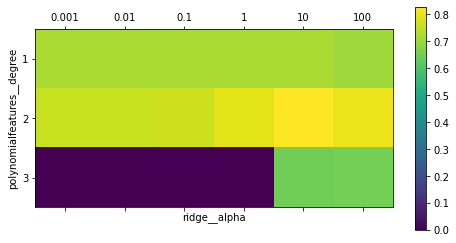

In [164]:
plt.matshow(Grid.cv_results_['mean_test_score'].reshape(3,-1), cmap="viridis", vmin=0)
plt.xlabel("ridge__alpha") 
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(params['ridge__alpha'])), params['ridge__alpha'])
plt.yticks(range(len(params['polynomialfeatures__degree'])), params['polynomialfeatures__degree'])
plt.colorbar();

In [165]:
Grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

In [167]:
Grid.score(Xtest, ytest)

0.7683045464100127

### run a grid search without polynomial features for comparison:

In [169]:
param_grid = {'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
pip2 = make_pipeline(StandardScaler(), Ridge())
Grid2 = GridSearchCV(pip2, param_grid, cv=5)
Grid2.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]})

In [171]:
Grid2.best_estimator_.steps

[('standardscaler', StandardScaler()), ('ridge', Ridge(alpha=10))]

In [172]:
Grid2.score(Xtest, ytest)

0.6272671927504456

# Grid-Searching Which Model To Use

In [174]:
pip3 = Pipeline([('pre',StandardScaler()), ('clf',SVC())])

In [176]:
from sklearn.ensemble import RandomForestClassifier

In [187]:
params = [{'clf':[SVC()], 'pre':[StandardScaler()], 'clf__C':[0.001, 0.01, 0.1, 1, 10, 100], 'clf__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}, {'clf':[RandomForestClassifier()], 'pre':[None], 'clf__max_features':[1,2,3]}]

In [188]:
grid4 = GridSearchCV(pip3, params, cv=5)

In [189]:
Xtrain, Xtest, ytrain, ytest = train_test_split(cancer.data, cancer.target, random_state=0)
grid4.fit(Xtrain, ytrain)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pre', StandardScaler()),
                                       ('clf', SVC())]),
             param_grid=[{'clf': [SVC(C=10, gamma=0.01)],
                          'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
                          'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                          'pre': [StandardScaler()]},
                         {'clf': [RandomForestClassifier()],
                          'clf__max_features': [1, 2, 3], 'pre': [None]}])

In [196]:
grid4.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('pre', StandardScaler()), ('clf', SVC())],
 'estimator__verbose': False,
 'estimator__pre': StandardScaler(),
 'estimator__clf': SVC(),
 'estimator__pre__copy': True,
 'estimator__pre__with_mean': True,
 'estimator__pre__with_std': True,
 'estimator__clf__C': 1.0,
 'estimator__clf__break_ties': False,
 'estimator__clf__cache_size': 200,
 'estimator__clf__class_weight': None,
 'estimator__clf__coef0': 0.0,
 'estimator__clf__decision_function_shape': 'ovr',
 'estimator__clf__degree': 3,
 'estimator__clf__gamma': 'scale',
 'estimator__clf__kernel': 'rbf',
 'estimator__clf__max_iter': -1,
 'estimator__clf__probability': False,
 'estimator__clf__random_state': None,
 'estimator__clf__shrinking': True,
 'estimator__clf__tol': 0.001,
 'estimator__clf__verbose': False,
 'estimator': Pipeline(steps=[('pre', StandardScaler()), ('clf', SVC())]),
 'n_jobs': None,
 'param_grid': [{'clf': [SVC(C=10, gamma=0.01)],
   'p

In [192]:
grid4.best_estimator_.get_params()

{'memory': None,
 'steps': [('pre', StandardScaler()), ('clf', SVC(C=10, gamma=0.01))],
 'verbose': False,
 'pre': StandardScaler(),
 'clf': SVC(C=10, gamma=0.01),
 'pre__copy': True,
 'pre__with_mean': True,
 'pre__with_std': True,
 'clf__C': 10,
 'clf__break_ties': False,
 'clf__cache_size': 200,
 'clf__class_weight': None,
 'clf__coef0': 0.0,
 'clf__decision_function_shape': 'ovr',
 'clf__degree': 3,
 'clf__gamma': 0.01,
 'clf__kernel': 'rbf',
 'clf__max_iter': -1,
 'clf__probability': False,
 'clf__random_state': None,
 'clf__shrinking': True,
 'clf__tol': 0.001,
 'clf__verbose': False}

In [195]:
grid4.best_score_ # inner validataion score

0.9858823529411765

In [193]:
grid4.score(Xtest, ytest)

0.9790209790209791